In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

#/content/gdrive/MyDrive/Colab Notebooks/Sentiment_analysis_data/

Mounted at /content/gdrive


In [91]:
#general purpose libraries
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [92]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [93]:
#Modelling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import pairwise_distances

In [94]:
data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Sentiment_analysis_data/sample30.csv')
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


## **Step 1**- *Sentiment Analysis on Product Reviews*

1.1 Data Cleaning and EDA

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

**Check for null values**

In [96]:
#Check for null values
data.isnull().sum()

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


**User Info**

reviews_userCity (~ 93% null) and reviews_userProvince (~ 99% null):

Too sparse → drop these columns. They won’t add meaningful signal.

In [97]:
data = data.drop(columns=["reviews_userCity", "reviews_userProvince"])

In [98]:
#discard the row where user_sentiment is blank
data = data.dropna(subset=['user_sentiment'])

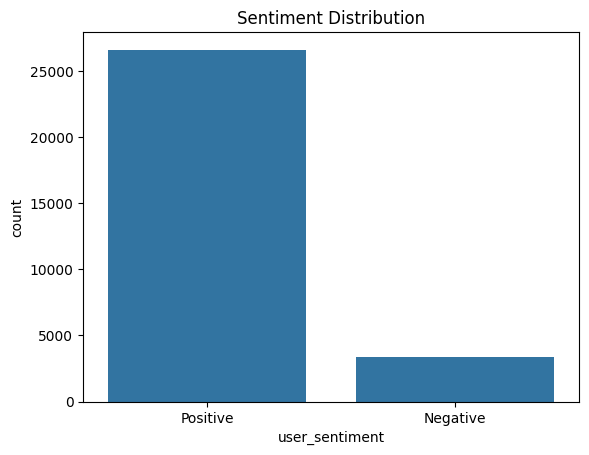

In [99]:
# Sentiment distribution
sns.countplot(x="user_sentiment", data=data)
plt.title("Sentiment Distribution")
plt.show()

In [100]:
data["reviews_rating"].value_counts()

,count
reviews_rating,
5,20830
4,6020
1,1384
3,1345
2,420


<Axes: xlabel='reviews_rating'>

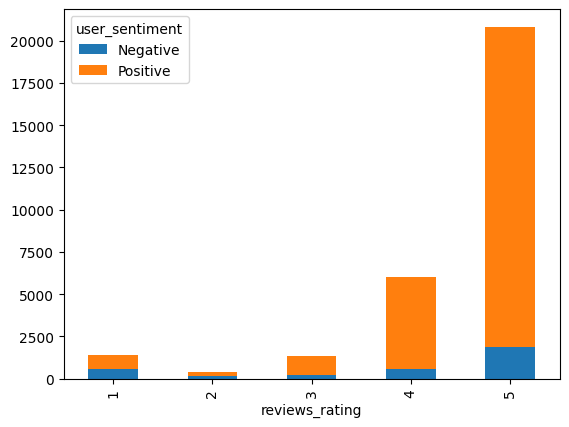

In [101]:
# Check sentiment distribution across ratings
data.groupby(['reviews_rating', 'user_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [13]:
#map the categorical user_sentiment to numerical 1 or 0
#data['user_sentiment'] = data['user_sentiment'].map({'Positive':1,'Negative':0})

**There seems to be some mismatch between user sentiment and ratings. Some rows with negative sentiments got 4-5 rating and some with positive got 1-2 rating.**

We will have to update the user sentiment to positive where rating is greater then or equal to 4 and update user sentiment to negative where rating is less then or equal to 2.

In [102]:
data.loc[(data['user_sentiment'] == 'Negative') & (data["reviews_rating"]>=4), "user_sentiment"] = 'Positive'

In [103]:
data.loc[(data['user_sentiment'] == 'Positive') & (data["reviews_rating"]<=2), "user_sentiment"] = 'Negative'

<Axes: xlabel='reviews_rating'>

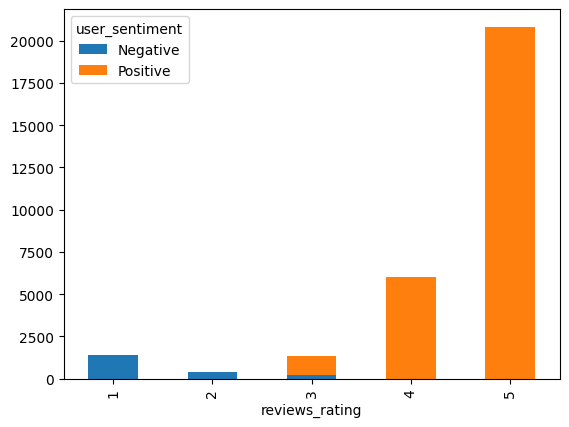

In [104]:
# Check sentiment distribution across ratings
data.groupby(['reviews_rating', 'user_sentiment']).size().unstack().plot(kind='bar', stacked=True)

Removing following columns as they will not be used for sentiment analysis -

*   reviews_doRecommend
*   reviews_didPurchase
*   brand
*   categories





In [105]:
data = data.drop(columns=["reviews_didPurchase", "reviews_doRecommend","brand", "categories"])

**Pre - Process and clean text columns like reviews_title and reviews_text**

In [106]:
# Fill missing titles with empty string
data["reviews_title"] = data["reviews_title"].fillna("")

In [107]:
# Combine title + text into one column (optional, gives richer input)
data["review_full"] = data["reviews_title"] + " " + data["reviews_text"]

In [108]:
data[["review_full", "user_sentiment"]].sample(10)

,review_full,user_sentiment
3993,"The Most Handy File Folder I use this product for expense reports that need to be compiled. I use one section for the receipts, one section for any notes, and another section for the finish expense report.",Positive
9455,Geat Product I love how clean these leave my surfaces. Great product and price. This review was collected as part of a promotion.,Positive
27654,Excellent This is a great movie for the entire family. They will love it.,Positive
28084,"Another great movie by Disney! Family, friendly movie which teaches a valuable lesson!",Positive
24361,Strong Opening The beginning grabs you well enough to make you hold on until the end...,Positive
15044,Ready Index Tabs Good product - good quality. The convenience of having tabs that can be easily personalized for whatever project you are working on is great. Avery has come through yet again with a product that works,Positive
22436,"Please Bring back old formula I used the original total care shampoo for a few years and I loved it. I got compliments on the look, feel, and scent of my hair daily, by far the best shampoo I and my family have ever used. Sadly that formula is replaced by a new and terrible formula. My hair now ...",Negative
23844,"King of Monsters Reigns Again To all Godzilla fans, old and new, this movie is the greatest. The Blu-ray is crisp, and it allows you to go to your favorite parts and watch them over and over again. The features are monster (pun intended) and give you a different perspective of all that goes into...",Positive
26050,Awesome movie on blu-ray Excellent movie to watch blu-ray. The blu-ray definitely makes a difference in things that you get (extras for movies) and the quality as well.,Positive
12667,"Awesome product Awesome product, cleans very well and smells great!! This review was collected as part of a promotion.",Positive


In [109]:
#function to clean text
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = str(text).lower()
    # remove HTML
    text = re.sub(r'<[^>]+>', ' ', text)
    # remove URLs
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    # non-alphanumeric to spaces
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

In [110]:
data["clean_review_text"] = data["review_full"].apply(clean_text)

In [111]:
# Discarding 'reviews_title', 'reviews_text' and 'review_full' columns
data = data.drop(columns=["reviews_title", "reviews_text","review_full"])

In [112]:
data.head()

,id,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,clean_review_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,joshua,Positive,awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,dorothy w,Positive,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,dorothy w,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,rebecca,Negative,disappointed read review looking buying one couple lubricant ultimately disappointed even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquid vaseline difficult clean pleasant especially since lacked capt...
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,walker557,Negative,irritation husband bought gel u gel caused irritation felt like burning skin recommend gel


In [113]:
data[["clean_review_text", "user_sentiment"]].sample(10)

,clean_review_text,user_sentiment
13917,awesome love product use everything kitchen cabinet countertop spot cleaning ceramic floor review collected part promotion,Positive
21698,change good product change product looking new gel seems every time find product really like company either discontinues change,Negative
10852,clorox disposable wipe use wipe around home put one kitchen bathroom one computer never know germ periodically wipe light switch doorknob refrigerator door garbage etc also keep small disposable car sick virus going around wipe steering wheel door handle also wipe handle purse bottom one believe...,Positive
29772,weightless love weightless feel conditioner hair smoothe yet perfectly coiffed drying used shampoo mask courtesy influenster review collected part promotion,Positive
2619,definitely second first first definitely better sequel sequel felt like trying hard achieve entertainment value first,Positive
14578,clorax love used clorax keep germ andi love lemon scent review collected part promotion,Positive
7708,lovely wipe easy live without wipe left car time review collected part promotion,Positive
25568,godzilla back blu ray awesome great picture sound best low end heard date,Positive
29231,good stuff start received product free test influenster would say one new favorite conditioner leaf hair feeling smooth love texture conditioner price point beat say conditioner work best shampoo pre shampoo treatment market new affordable conditioner one check list review collected part promotion,Positive
26254,great sauce packed well keep breaking,Positive


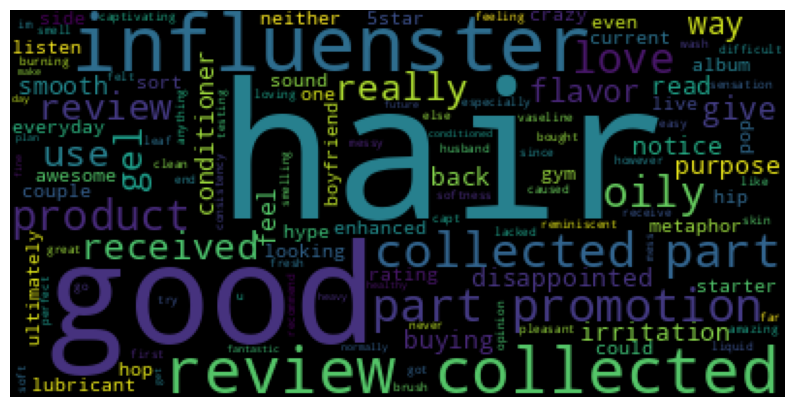

In [114]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=200).generate(str(data['clean_review_text']))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

**1.2 Feature Extraction**

In [115]:
#map the categorical user_sentiment to numerical 1 or 0
data['user_sentiment'] = data['user_sentiment'].map({'Positive':1,'Negative':0})

In [116]:
X = data["clean_review_text"]
y = data["user_sentiment"]

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=700)
X_tfidf = vectorizer.fit_transform(X)

print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (29999, 700)


In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (23999, 700) Test size: (6000, 700)


**Check Class Imbalance**

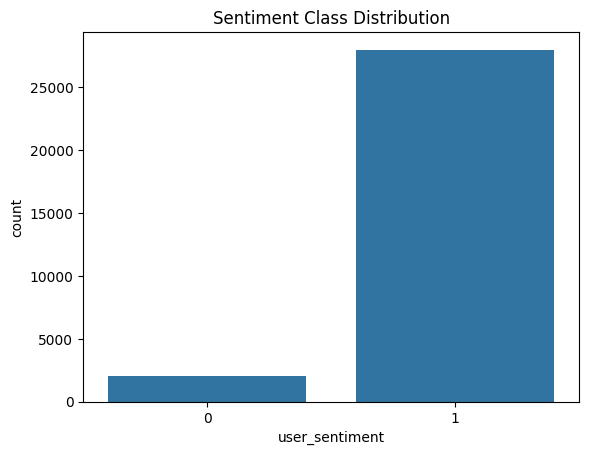

user_sentiment
1    93.25
0     6.75
Name: proportion, dtype: float64


In [118]:

sns.countplot(x=data['user_sentiment'])
plt.title("Sentiment Class Distribution")
plt.show()

# Print exact counts
print(data['user_sentiment'].value_counts(normalize=True) * 100)

Severe Class Imbalance Observed
**bold text**
The dataset is highly skewed towards positive sentiment (93.25%), with negative sentiment making up only 6.75%

for removing imbalance we will be using SMOTE

In [119]:
counter = Counter(y_train)
print('Before',counter)

sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 22380, 0: 1619})
After Counter({0: 22380, 1: 22380})


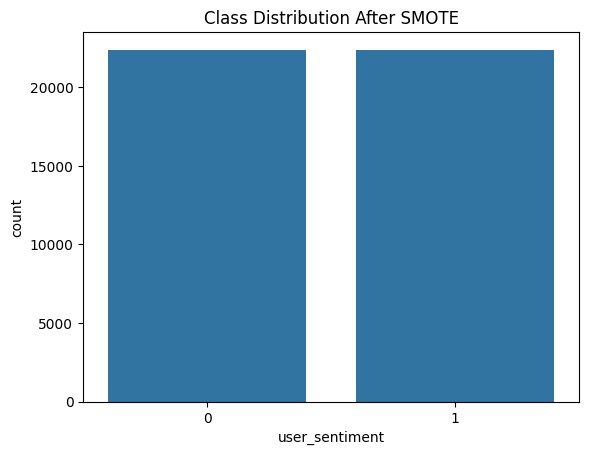

In [120]:
sns.countplot(x=y_train)
plt.title("Class Distribution After SMOTE")
plt.show()

1.4 Train Models

In [121]:
# Logistic Regression
logreg = LogisticRegression(max_iter=500, class_weight="balanced")
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [122]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [123]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

In [124]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

📊 Model Comparison Table


,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.96,0.96,0.96,0.96
1,XGBoost,0.94,0.95,0.94,0.95
2,Logistic Regression,0.92,0.95,0.92,0.93
3,Naive Bayes,0.89,0.94,0.89,0.91


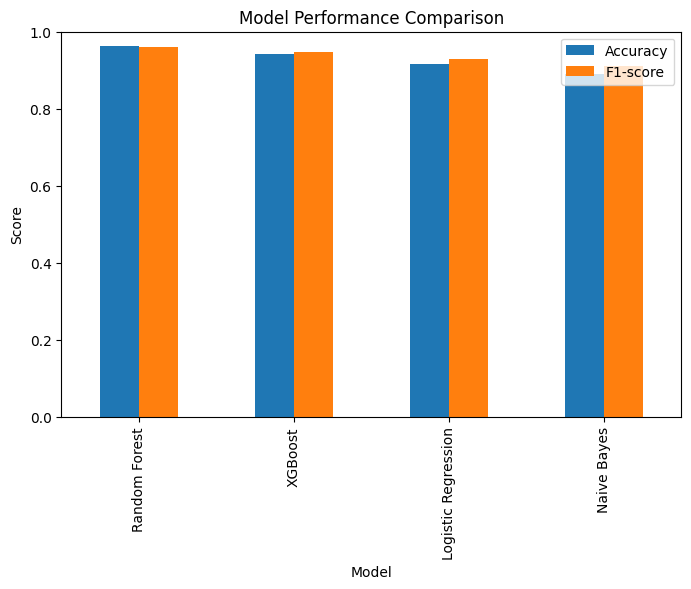

In [125]:
# ==========================================
# 11. Model Comparison Table
# ==========================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def get_scores(y_true, y_pred, name):
    return {
        "Model": name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1-score": f1_score(y_true, y_pred, average="weighted"),
    }

results = []
results.append(get_scores(y_test, y_pred_logreg, "Logistic Regression"))
results.append(get_scores(y_test, y_pred_rf, "Random Forest"))
results.append(get_scores(y_test, y_pred_xgb, "XGBoost"))
results.append(get_scores(y_test, y_pred_nb, "Naive Bayes"))

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="F1-score", ascending=False).reset_index(drop=True)

# Display results
import matplotlib.pyplot as plt

print("📊 Model Comparison Table")
display(results_df)

# Barplot for quick comparison
results_df.set_index("Model")[["Accuracy", "F1-score"]].plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()


In [126]:
import pickle
import os

def save_object(obj, filename):
    folder = "pickle"
    os.makedirs(folder, exist_ok=True)  # Ensure directory exists
    filepath = os.path.join(folder, filename + '.pkl')
    with open(filepath, 'wb') as file:
        pickle.dump(obj, file)

# Save best XGBoost model after tuning
save_object(xgb, 'sentiment-classification-xg-boost')

# Save features used for model building
save_object(data, 'cleaned-data')


# Save TF-IDF vectorizer for text data
save_object(vectorizer, 'tfidf-vectorizer')

## **Step 2**- *Building a recommendation system*

We have ratings (reviews_rating) and user IDs (reviews_username).
That means we can use Collaborative Filtering (CF) instead of Content-based filtering.

User-based CF → Find similar users and recommend what they liked.

Item-based CF → Find similar products based on rating patterns and recommend them to the user.

In [127]:
data_recommendation = data[["id", "name", "reviews_rating", "reviews_username"]]

In [128]:
#splitting the train and test
train, test = train_test_split(data_recommendation, test_size=0.25, random_state=42)

In [129]:
print(train.shape)
print(test.shape)

(22499, 4)
(7500, 4)


In [130]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [131]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

Creating dummy train and test

In [132]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [133]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
21177,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,bobdigi
23942,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,skeeter
1247,AV1YneDPglJLPUi8IJyQ,"Finish Quantum Dishwasher Detergent, Lemon Sparkle Scent, 45 Count",5,mruduka
23622,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,kiddro3523
28455,AVpftikC1cnluZ0-p31V,"Storkcraft Tuscany Glider and Ottoman, Beige Cushions, Espresso Finish",1,murdook


In [134]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [135]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

User similarity matrix

In [136]:
df_pivot.index.nunique()

19376

In [137]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]
(19376, 19376)


Prediction User-User

In [138]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [139]:

user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 2.39045722, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [140]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

Find 20 recommendation for the user

In [141]:
user_input = "joshua"
print(user_input)

joshua


In [142]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

,joshua
id,
AVpfPaoqLJeJML435Xk9,46.66
AVpfRTh1ilAPnD_xYic2,16.45
AVpf0eb2LJeJML43EVSt,16.03
AVpe41TqilAPnD_xQH3d,12.35
AVpe59io1cnluZ0-ZgDU,11.38
AVpfM_ytilAPnD_xXIJb,8.12
AVpf5olc1cnluZ0-tPrO,6.51
AVpfR5m0LJeJML436K3W,5.51
AVpfPnrU1cnluZ0-g9rL,4.90


In [143]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,46.66
2477,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),16.45
3350,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),16.03
3989,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),12.35
4562,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),11.38
5057,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,8.12
5252,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,6.51
5380,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5.51
5531,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),4.90
5674,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,4.58


Evaluation User-User

In [144]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1768, 4)

In [145]:
common.head()

,id,name,reviews_rating,reviews_username
2308,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5,iplsports
22404,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,1,crysv
11311,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,billybob789
19043,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,fatz
9482,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,natalie4717


In [146]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [147]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19276,19277,19278,19279,19280,19281,19282,19283,19284,19285,19286,19287,19288,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298,19299,19300,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310,19311,19312,19313,19314,19315,19316,19317,19318,19319,19320,19321,19322,19323,19324,19325,19326,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.

In [148]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19276,19277,19278,19279,19280,19281,19282,19283,19284,19285,19286,19287,19288,19289,19290,19291,19292,19293,19294,19295,19296,19297,19298,19299,19300,19301,19302,19303,19304,19305,19306,19307,19308,19309,19310,19311,19312,19313,19314,19315,19316,19317,19318,19319,19320,19321,19322,19323,19324,19325,19326,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.62,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
01impala,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.6,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.71,0.0,0.0,0.0,0.71,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.51,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0

In [149]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [150]:
user_correlation_df_1.shape

(1512, 19376)

In [151]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [152]:
user_correlation_df_3 = user_correlation_df_2.T

In [153]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[ 0.        ,  1.64253443,  0.        , ...,  0.        ,
         2.29174624,  1.        ],
       [ 3.10190162, 10.77558673,  0.        , ...,  3.53553391,
         0.        ,  3.53553391],
       [ 0.        ,  3.12347524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.5       ,  4.92031173,  0.        , ...,  5.        ,
         0.        ,  5.        ],
       [ 0.        ,  3.12347524,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 2.33205081,  6.1912015 ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [154]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [155]:
dummy_test.shape

(1512, 120)

In [156]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [157]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [158]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [159]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfkIiYilAPnD_xeEjr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfnRuSilAPnD_xfB8l,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfshNsLJeJML43CB8q,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [160]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [161]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [162]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [163]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1614078875295144


**Item Based Recommendation**

In [164]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2rogersmakearight,2shoes,...,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zeek,zeek09,zegan,zenanuts,zenmon,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [165]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [166]:
df_subtracted.head()

reviews_username,00dog3,00sab00,01impala,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1234,1234561,1234567,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,132457,13ld,13thfaerie,1421nikki,143st,1515,15425shopper,1616,1753,17roses,1863philly,1943,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1gamer,1glenn,1gra,1gussy,1happymom,1healthytot,1hotmama,1izzy1,1jodie,1movielover2,1nikki31t,1okc2thunder3up4,1olaygal,1pleasedclient,1scooby1,1stcavdivision,1stgrade,1sungirl,1texasmom,1tomg,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016,2016home,2016parker10,2062351337,20crafter16,2175046722,21please,232323,23jen,2532674594,25happyshopper,262jennifer,2827,28green,295259,2athome,2bgreen,2big,2busy4u,2choclabs,2clean4me,2ds4es14,2forhokies,2go4savings,2hearts1love,2iceskates,2rogersmakearight,2shoes,...,yozer29,ypryor,yram,yrina03,yshan,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yyz2112123,yzkgsx,z33pisces,z992,zabdelra,zach,zacharymcneill,zachizz,zachsmom,zaibo,zak,zak08,zakkzakk,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zara0215,zara07,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zebrastrong,zee74,zeek,zeek09,zegan,zenanuts,zenmon,zeramm,zero,zetamom,zfem2,zhjwpp,zhynellebb,zibby4,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zoeellasca,zoey,zoeyny,zokhid,zombie,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zulaa118,zuttle,zxcsdfd,zxjki,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [167]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [168]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Prediction - item-item

In [169]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Filtering the rating only for the products not rated by the user for recommendation

In [170]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7HOwilAPnD_xkl3L,...,AVpfKOYiilAPnD_xWOFw,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfRxSkilAPnD_xYrzm,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVp

Finding the top 20 recommendation for the user

In [171]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

08dallas


In [172]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

,08dallas
id,
AVpe8xjUilAPnD_xRkxC,4.93e-02
AVpf7I3i1cnluZ0-tnL6,4.68e-02
AVpe41TqilAPnD_xQH3d,4.38e-02
AVpf0eb2LJeJML43EVSt,2.37e-02
AVpf2tw1ilAPnD_xjflC,2.27e-02
AVpf385g1cnluZ0-s0_t,1.47e-02
AVpfoSS51cnluZ0-oVH9,1.43e-02
AVpfR5m0LJeJML436K3W,1.05e-02
AVpfJP1C1cnluZ0-e3Xy,2.40e-03


In [173]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,4.93e-02
12,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,4.68e-02
35,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.38e-02
608,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),2.37e-02
1247,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),2.27e-02
1764,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",1.47e-02
1911,AVpfoSS51cnluZ0-oVH9,Cheetos Crunchy Flamin' Hot Cheese Flavored Snacks,1.43e-02
1960,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,1.05e-02
2111,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,2.40e-03
3659,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,1.65e-03


In [181]:
train, test = train_test_split(data_recommendation, test_size=0.25, random_state=42)

Evaluation - item-item

In [195]:
common =  test[test.id.isin(train.id)]
common.shape

(7486, 4)

In [196]:
common.head(4)

,id,name,reviews_rating,reviews_username
2308,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),5,iplsports
22404,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,1,crysv
23397,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4,sammhc12
25058,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,spyder


In [197]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [198]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [199]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,8.39e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.97e-03,0.0,0.0,0.0,0.0,2.80e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.95e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.61

In [200]:
list_name = common.id.tolist()

In [201]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [202]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [203]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf99c6LJeJML43Gu3K,AVpf9UGp1cnluZ0-uITX,AVpf9_3MLJeJML43GvdB,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfAkX91cnluZ0-b4d8,AVpfBO2vLJeJML430mGh,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfCi3kilAPnD_xTn3k,AVpfCjEEilAPnD_xTn75,AVpfCuzrilAPnD_xTroT,AVpfCvKt1cnluZ0-cpI2,AVpfD9xTLJeJML431ig2,AVpfDA6wilAPnD_xTxdg,AVpfDI3xilAPnD_xTz-k,AVpfD_NRilAPnD_xUG56,AVpfDiTDLJeJML431Y21,AVpfE5UF1cnluZ0-dY1N,AVpfELcXLJeJML431naf,AVpfEqruilAPnD_xUWDr,AVpfFTpK1cnluZ0-diMS,AVpfFs_1ilAPnD_xUtRm,AVpfFymYilAPnD_xUvMh,AVpfGRUHilAPnD_xU5nU,AVpfGTRQLJeJML432WYA,AVpfG_ujilAPnD_xVI8L,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfHf4wLJeJML432vqK,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKOYiilAPnD_xWOFw,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOmKwLJeJML435GM7,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfgvkJLJeJML43-g1y,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [204]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [205]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [206]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [207]:
from sklearn.preprocessing import MinMaxScaler

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [208]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [209]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.570182213962442


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [210]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [211]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = data[data.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  vectorizer.transform(temp["clean_review_text"].values.astype(str))
        temp["predicted_sentiment"]= xgb.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [212]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("joshua")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8506,8545,99.54
3,Clorox Disinfecting Bathroom Cleaner,2039,2011,2039,98.63
13,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1124,1142,98.42
0,100:Complete First Season (blu-Ray),139,135,139,97.12
15,The Resident Evil Collection 5 Discs (blu-Ray),845,814,845,96.33
14,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,179,186,96.24
10,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),668,639,668,95.66
16,There's Something About Mary (dvd),130,122,130,93.85
6,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3325,3097,3325,93.14
8,Jason Aldean - They Don't Know,204,186,204,91.18


In [213]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("joshua")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8506,8545,99.54
3,Clorox Disinfecting Bathroom Cleaner,2039,2011,2039,98.63
13,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1124,1142,98.42
0,100:Complete First Season (blu-Ray),139,135,139,97.12
15,The Resident Evil Collection 5 Discs (blu-Ray),845,814,845,96.33
14,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,179,186,96.24
10,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),668,639,668,95.66
16,There's Something About Mary (dvd),130,122,130,93.85
6,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3325,3097,3325,93.14
8,Jason Aldean - They Don't Know,204,186,204,91.18


In [214]:
#get the top 5
get_sentiment_recommendations("joshua")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
4,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8545,8506,8545,99.54
3,Clorox Disinfecting Bathroom Cleaner,2039,2011,2039,98.63
13,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1124,1142,98.42
0,100:Complete First Season (blu-Ray),139,135,139,97.12
15,The Resident Evil Collection 5 Discs (blu-Ray),845,814,845,96.33
